In [1]:
import numpy as np
np.random.seed(1335)  # for reproducibility
np.set_printoptions(precision=5, suppress=True, linewidth=150)

In [2]:
import pandas as pd
import backtest as twp
from matplotlib import pyplot as plt
from sklearn import metrics, preprocessing

In [3]:
#Load data
def load_data():
    price = np.arange(20) #linearly increasing prices
    return price

In [4]:
#Initialize first state, all items are placed deterministically
def init_state(data):
    
    close = data
    diff = np.diff(data)
    diff = np.insert(diff, 0, 0)
    
    #--- Preprocess data
    xdata = np.column_stack((close, diff))
    xdata = np.nan_to_num(xdata)
    scaler = preprocessing.StandardScaler()
    xdata = scaler.fit_transform(xdata)
    
    state = xdata[0:1, :]
    return state, xdata

In [5]:
#Take Action
def take_action(state, xdata, action, signal, time_step):
    #this should generate a list of trade signals that at evaluation time are fed to the backtester
    #the backtester should get a list of trade signals and a list of price data for the asset
    
    #make necessary adjustments to state and then return it
    time_step += 1
    
    #if the current iteration is the last state ("terminal state") then set terminal_state to 1
    if time_step == xdata.shape[0]:
        state = xdata[time_step-1:time_step, :]
        terminal_state = 1
        signal.loc[time_step] = 0
        return state, time_step, signal, terminal_state

    #move the market data window one step forward
    state = xdata[time_step-1:time_step, :]
    #take action 1 for long? 2 for short? 3 for stay? what about 0??
    if action != 0:
        if action == 1:
            signal.loc[time_step] = 100
        elif action == 2:
            signal.loc[time_step] = -100
        elif action == 3:
            signal.loc[time_step] = 0
    
    terminal_state = 0

    return state, time_step, signal, terminal_state

In [6]:
#Get Reward, the reward is returned at the end of an episode
def get_reward(new_state, time_step, action, xdata, signal, terminal_state, epoch=0): # "epoch=0" migght be useless
    reward = 0
    signal.fillna(value=0, inplace=True)
    if terminal_state == 0:
        #get reward for the most current action
        if signal[time_step] != signal[time_step-1] and terminal_state == 0:
            i=1
            while signal[time_step-i] == signal[time_step-1-i] and time_step - 1 - i > 0:
                i += 1
            reward = (xdata[time_step-1, 0] - xdata[time_step - i-1, 0]) * signal[time_step - 1] * -100. + i*np.abs(signal[time_step - 1])/10.
        if signal[time_step] == 0 and signal[time_step - 1] == 0:
            reward -= 10

    #calculate the reward for all actions if the last iteration in set
    if terminal_state == 1:
        #run backtest, send list of trade signals and asset data to backtest function
        bt = twp.Backtest(pd.Series(data=[x[0] for x in xdata]), signal, signalType='shares')
        reward = bt.pnl.iloc[-1]

    return reward

### Run game

In [7]:
indata = load_data()
state, xdata = init_state(indata)
signal = pd.Series(index=np.arange(len(indata)))
time_step = 1

/home/kian/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kian/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
pd.DataFrame(xdata).values

array([[-1.64751, -4.3589 ],
       [-1.47409,  0.22942],
       [-1.30066,  0.22942],
       [-1.12724,  0.22942],
       [-0.95382,  0.22942],
       [-0.7804 ,  0.22942],
       [-0.60698,  0.22942],
       [-0.43355,  0.22942],
       [-0.26013,  0.22942],
       [-0.08671,  0.22942],
       [ 0.08671,  0.22942],
       [ 0.26013,  0.22942],
       [ 0.43355,  0.22942],
       [ 0.60698,  0.22942],
       [ 0.7804 ,  0.22942],
       [ 0.95382,  0.22942],
       [ 1.12724,  0.22942],
       [ 1.30066,  0.22942],
       [ 1.47409,  0.22942],
       [ 1.64751,  0.22942]])

In [9]:
new_state

NameError: name 'new_state' is not defined

In [ ]:
new_state, time_step, signal, terminal_state = take_action(state, xdata, 1, signal, time_step)
print new_state, time_step, signal, terminal_state

In [ ]:
reward = get_reward(new_state, time_step, 1, xdata, signal, terminal_state)
print reward

In [ ]:
xdata

In [ ]:
if terminal_state == 0:
    #get reward for the most current action
    if signal[time_step] != signal[time_step-1] and terminal_state == 0:
        i=1
        while signal[time_step-i] == signal[time_step-1-i] and time_step - 1 - i > 0:
            i += 1
        reward = (xdata[time_step-1, 0] - xdata[time_step -i-1, 0]) * signal[time_step - 1] * -100. + i*np.abs(signal[time_step - 1])/10.
    if signal[time_step] == 0 and signal[time_step - 1] == 0:
        reward -= 10

In [ ]:
signal[time_step]

In [ ]:
(xdata[time_step-1, 0] - xdata[time_step - i-1, 0])

In [ ]:
signal[time_step]

In [ ]:
xdata[time_step-1, 0]

In [ ]:
xdata

In [10]:
# Below is just helper function
def evaluate_Q(eval_data, eval_model):
    #This function is used to evaluate the perofrmance of the system each epoch, without the influence of epsilon and random actions
    signal = pd.Series(index=np.arange(len(eval_data)))
    state, xdata = init_state(eval_data)
    status = 1
    terminal_state = 0
    time_step = 1
    while(status == 1):
        #We start in state S
        #Run the Q function on S to get predicted reward values on all the possible actions
        qval = eval_model.predict(state.reshape(1,2), batch_size=1)
        action = (np.argmax(qval))
        #Take action, observe new state S'
        new_state, time_step, signal, terminal_state = take_action(state, xdata, action, signal, time_step)
        #Observe reward
        eval_reward = get_reward(new_state, time_step, action, xdata, signal, terminal_state, i)
        state = new_state
        if terminal_state == 1: #terminal state
            status = 0
    return eval_reward

### NN

In [11]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(4, init='lecun_uniform', input_shape=(2,)))
model.add(Activation('relu'))
#model.add(Dropout(0.2)) I'm not using dropout in this example

model.add(Dense(4, init='lecun_uniform'))
model.add(Activation('relu'))
#model.add(Dropout(0.2))

model.add(Dense(4, init='lecun_uniform'))
model.add(Activation('linear')) #linear output so we can have range of real-valued outputs

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)

Using TensorFlow backend.


/home/kian/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kian/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kian/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kian/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kian/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with i

Epoch #: 0 Reward: 121.395396 Epsilon: 1.000000
Epoch #: 1 Reward: 86.710997 Epsilon: 0.900000
Epoch #: 2 Reward: 121.395396 Epsilon: 0.800000
Epoch #: 3 Reward: 121.395396 Epsilon: 0.700000


/home/kian/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kian/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kian/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kian/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kian/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with i

Epoch #: 4 Reward: 138.737595 Epsilon: 0.600000
Epoch #: 5 Reward: 138.737595 Epsilon: 0.500000
Epoch #: 6 Reward: 138.737595 Epsilon: 0.400000


/home/kian/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kian/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kian/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kian/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kian/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with i

Epoch #: 7 Reward: 138.737595 Epsilon: 0.300000
Epoch #: 8 Reward: 138.737595 Epsilon: 0.200000
Epoch #: 9 Reward: 156.079795 Epsilon: 0.100000
Completed in 0.970000
       price  shares       value        cash           pnl  delta
0  -1.647509     0.0   -0.000000    0.000000  0.000000e+00    0.0
1  -1.474087     0.0   -0.000000    0.000000  0.000000e+00    0.0
2  -1.300665   100.0 -130.066495  130.066495  0.000000e+00  100.0
3  -1.127243   100.0 -112.724296  130.066495  1.734220e+01    0.0
4  -0.953821  -100.0   95.382097  -60.697698  3.468440e+01 -200.0
5  -0.780399  -100.0   78.039897  -60.697698  1.734220e+01    0.0
6  -0.606977  -100.0   60.697698  -60.697698  2.131628e-14    0.0
7  -0.433555     0.0   -0.000000  -17.342199 -1.734220e+01  100.0
8  -0.260133     0.0   -0.000000  -17.342199 -1.734220e+01    0.0
9  -0.086711     0.0   -0.000000  -17.342199 -1.734220e+01    0.0
10  0.086711     0.0    0.000000  -17.342199 -1.734220e+01    0.0
11  0.260133   100.0   26.013299  -43.3554

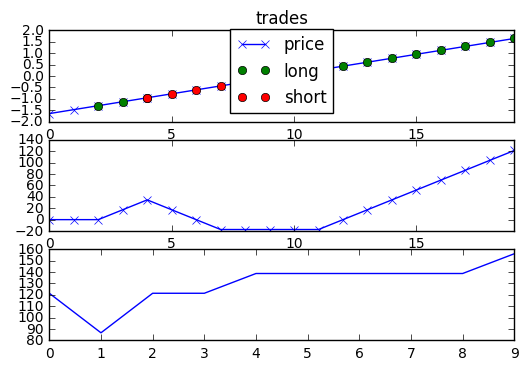

In [12]:
import random, timeit

start_time = timeit.default_timer()

indata = load_data()
epochs = 10
gamma = 0.9 #a high gamma makes a long term reward more valuable
epsilon = 1.
learning_progress = []
#stores tuples of (S, A, R, S')
h = 0
signal = pd.Series(index=np.arange(len(indata)))
for i in range(epochs):

    state, xdata = init_state(indata)
    status = 1
    terminal_state = 0
    time_step = 1
    #while learning is still in progress
    while(status == 1):
        #We start in state S
        #Run the Q function on S to get predicted reward values on all the possible actions
        qval = model.predict(state.reshape(1,2), batch_size=1)
        if (random.random() < epsilon) and i != epochs - 1: #maybe choose random action if not the last epoch
            action = np.random.randint(0,4) #assumes 4 different actions
        else: #choose best action from Q(s,a) values
            action = (np.argmax(qval))
        #Take action, observe new state S'
        new_state, time_step, signal, terminal_state = take_action(state, xdata, action, signal, time_step)
        #Observe reward
        reward = get_reward(new_state, time_step, action, xdata, signal, terminal_state, i)
        #Get max_Q(S',a)
        newQ = model.predict(new_state.reshape(1,2), batch_size=1)
        maxQ = np.max(newQ)
        y = np.zeros((1,4))
        y[:] = qval[:]
        if terminal_state == 0: #non-terminal state
            update = (reward + (gamma * maxQ))
        else: #terminal state (means that it is the last state)
            update = reward
        y[0][action] = update #target output
        model.fit(state.reshape(1,2), y, batch_size=1, nb_epoch=1, verbose=0)
        state = new_state
        if terminal_state == 1: #terminal state
            status = 0
    eval_reward = evaluate_Q(indata, model)
    print("Epoch #: %s Reward: %f Epsilon: %f" % (i,eval_reward, epsilon))
    learning_progress.append((eval_reward))
    if epsilon > 0.1:
        epsilon -= (1.0/epochs)

elapsed = np.round(timeit.default_timer() - start_time, decimals=2)
print("Completed in %f" % (elapsed,))

#plot results
bt = twp.Backtest(pd.Series(data=[x[0] for x in xdata]), signal, signalType='shares')
bt.data['delta'] = bt.data['shares'].diff().fillna(0)

print(bt.data)

plt.figure()
bt.plotTrades()
plt.suptitle('epoch' + str(i))
plt.savefig('plt/final_trades'+'.png', bbox_inches='tight', pad_inches=1, dpi=72) #assumes there is a ./plt dir
plt.close('all')

plt.figure()
plt.subplot(3,1,1)
bt.plotTrades()
plt.subplot(3,1,2)
bt.pnl.plot(style='x-')
plt.subplot(3,1,3)
plt.plot(learning_progress)

plt.show()

In [14]:
state.reshape(1,2)

array([[ 1.64751,  0.22942]])